# Analyze System
The purpose of this notebook is to analyze the .csv files (results, data) created from predictsystem.ipynb, and generate candidates for full long Nbody simulations.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import rebound
%matplotlib inline

## Load data

In [5]:
system = "KOI-2086"    #KOI-0156, KOI-0168, KOI-2086

#load data and predicted stability probabilities
data = pd.read_csv("systems/%s_data.csv"%system)
results = pd.read_csv("systems/%s_results.csv"%system)
Ms = {}; Ms["KOI-0156"] = 0.56; Ms["KOI-0168"] = 1.11; Ms["KOI-2086"] = 1.04
epoch = 780

#get e
data["e1"] = np.sqrt(data["h1"]**2 + data["k1"]**2)
data["e2"] = np.sqrt(data["h2"]**2 + data["k2"]**2)
data["e3"] = np.sqrt(data["h3"]**2 + data["k3"]**2)

#load Nbody results
columns = ["name","id","shadow","maxorbs","P1","time","dE","elapsed_time"]
try:
    Nbody = pd.read_csv("systems/%s_Nbodyresults.csv"%system,names=columns)
except:
    print "Nbody results does not exist for this system yet."

## Plot Stability Predictions

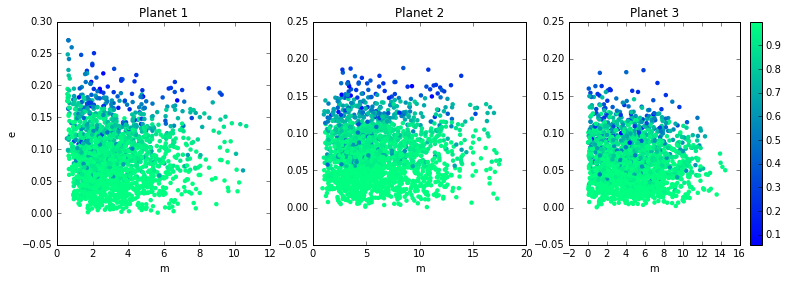

In [13]:
x = "m"
y = "e"
proba = results["predict_proba"].values

colorbar = 'winter'
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[13, 4])
ax1.scatter(data["%s1"%x][:len(proba)], data["%s1"%y][:len(proba)], c=proba, cmap=colorbar, lw=0)
ax2.scatter(data["%s2"%x][:len(proba)], data["%s2"%y][:len(proba)], c=proba, cmap=colorbar, lw=0)
c=ax3.scatter(data["%s3"%x][:len(proba)], data["%s3"%y][:len(proba)], c=proba, cmap=colorbar, lw=0)

ax1.set_ylabel(y) 
ax1.set_xlabel(x)
ax2.set_xlabel(x)
ax3.set_xlabel(x)
ax1.set_title("Planet 1")
ax2.set_title("Planet 2")
ax3.set_title("Planet 3")
cb = f.colorbar(c)
plt.savefig("images/%s_%s%s.png"%(system,x,y))

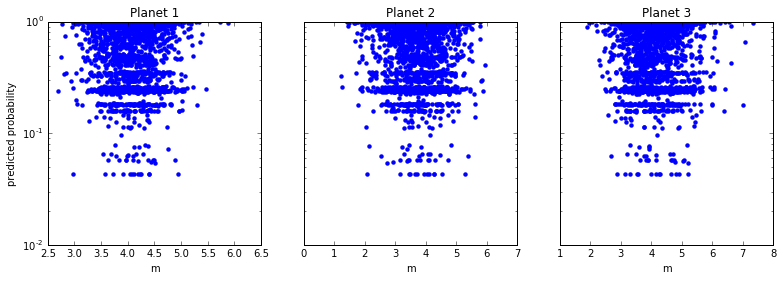

In [9]:
proba = results["predict_proba"].values

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[13, 4], sharey=True)
ax1.scatter(data["m1"][:len(proba)], proba, lw=0)
ax2.scatter(data["m2"][:len(proba)], proba, lw=0)
ax3.scatter(data["m3"][:len(proba)], proba, lw=0)

ax1.set_ylabel("predicted probability") 
ax1.set_yscale('log')
ax1.set_ylim([1e-2,1])
ax1.set_xlabel("m")
ax2.set_xlabel("m")
ax3.set_xlabel("m")
ax1.set_title("Planet 1")
ax2.set_title("Planet 2")
ax3.set_title("Planet 3")
plt.savefig("images/%s_mproba.png"%system)

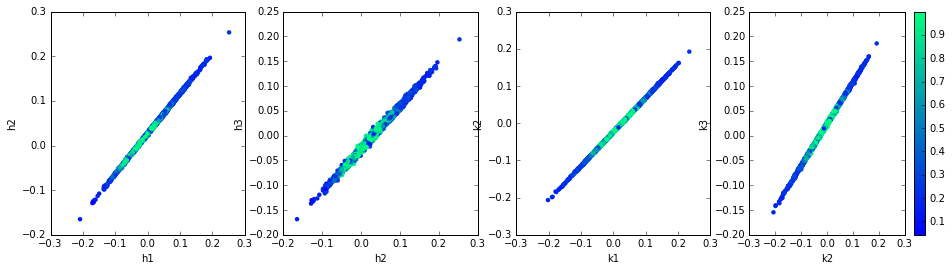

In [8]:
# h of neighboring pairs and k of neighboring pairs
x = "h"
y = "k"
proba = results["predict_proba"].values

colorbar = 'winter'
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=[16, 4])
ax1.scatter(data["%s1"%x], data["%s2"%x], c=proba, cmap=colorbar, lw=0)
ax2.scatter(data["%s2"%x], data["%s3"%x], c=proba, cmap=colorbar, lw=0)
ax3.scatter(data["%s1"%y], data["%s2"%y], c=proba, cmap=colorbar, lw=0)
c=ax4.scatter(data["%s2"%y], data["%s3"%y], c=proba, cmap=colorbar, lw=0)

ax1.set_ylabel("%s2"%x) 
ax1.set_xlabel("%s1"%x)
ax2.set_ylabel("%s3"%x)
ax2.set_xlabel("%s2"%x)
ax3.set_ylabel("%s2"%y) 
ax3.set_xlabel("%s1"%y)
ax4.set_ylabel("%s3"%y)
ax4.set_xlabel("%s2"%y)
cb = f.colorbar(c)
plt.savefig("images/%s_%s%s_in_vs_out.png"%(system,x,y))

## Analyze/Plot Results of Nbody Simulations

In [8]:
#create shadow0 and shadow1 arrays
shadow0 = Nbody[Nbody["shadow"]==0].copy()
shadow1 = Nbody[Nbody["shadow"]==1].copy()
r0 = results.iloc[shadow0["id"]]
d0 = data.iloc[shadow0["id"]]
r1 = results.iloc[shadow1["id"]]
d1 = data.iloc[shadow1["id"]]
shadow0["orbital_periods"] = shadow0["time"]/(d0["P1"].values*2*np.pi/365)
shadow1["orbital_periods"] = shadow1["time"]/(d1["P1"].values*2*np.pi/365)
shadow0["predict_proba"] = r0["predict_proba"].values
shadow1["predict_proba"] = r1["predict_proba"].values

params = ["h1","k1","h2","k2","h3","k3"]
#add orbital parameters of interest
for p in params:
    shadow0[p] = d0[p].values
    shadow1[p] = d1[p].values
shadow1.head()

,name,id,shadow,maxorbs,P1,time,dE,elapsed_time,orbital_periods,predict_proba,h1,k1,h2,k2,h3,k3
0,KOI-2086_1e9orbits_id167_shadow1,167,1,1.000000e+09,7.133089,458647.6,0.001450,284.3986,3.735205e+06,0.064455,-0.124398,-0.028044,-0.089299,-0.046481,-0.096840,-0.020262
1,KOI-2086_1e9orbits_id1563_shadow1,1563,1,1.000000e+09,7.133249,1099105.0,0.000064,385.5704,8.950860e+06,0.051029,0.011759,0.119112,0.035880,0.087989,0.013680,0.091888
2,KOI-2086_1e9orbits_id1193_shadow1,1193,1,1.000000e+09,7.133179,1017611.0,0.000382,424.9990,8.287274e+06,0.159591,-0.166276,-0.004491,-0.125906,-0.025049,-0.130187,-0.001872
3,KOI-2086_1e9orbits_id86_shadow1,86,1,1.000000e+09,7.133197,1967244.0,0.001190,1225.7240,1.602090e+07,0.179718,-0.013979,0.181035,0.017391,0.143591,-0.018225,0.144860
4,KOI-2086_1e9orbits_id1555_shadow1,1555,1,1.000000e+09,7.133307,2025459.0,0.000008,1340.3600,1.649474e+07,0.179718,-0.115804,0.090343,-0.077590,0.059049,-0.096625,0.072819


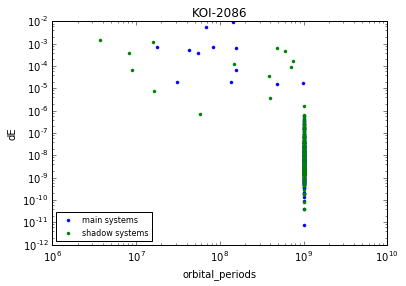

In [10]:
#2D plots
x = "orbital_periods"
y = "dE"

plt.plot(shadow0[x], shadow0[y],'.',label='main systems')
plt.plot(shadow1[x], shadow1[y],'.',label='shadow systems')
plt.xlabel(x)
plt.ylabel(y)
plt.yscale('log')
plt.xscale('log')
plt.title(system)
plt.legend(loc='lower left',fontsize=8,numpoints=1)
plt.savefig('images/Nbody-%s_%sv%s.png'%(system,x,y))

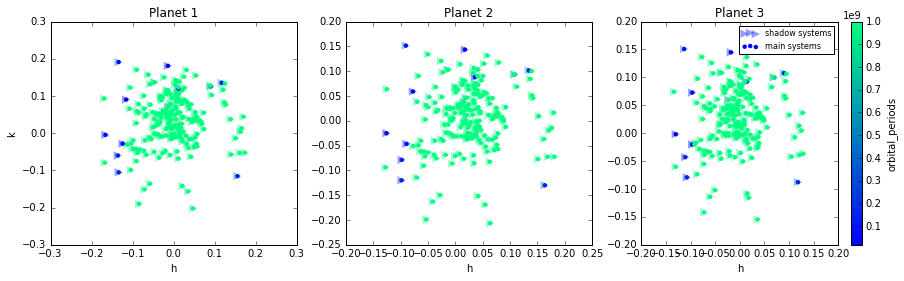

In [81]:
# 3D plots
x = "h"
y = "k"
c = "orbital_periods"

s = 70   #size of markers
m = ">"  #marker for shadow systems
alpha = 0.4 #alpha for shadow systems
colorbar = 'winter'

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[15, 4])
ax1.scatter(shadow1["%s1"%x], shadow1["%s1"%y], c=shadow1[c], marker=m, s=s, alpha=alpha, cmap=colorbar, lw=0, label='shadow systems')
ax1.scatter(shadow0["%s1"%x], shadow0["%s1"%y], c=shadow0[c], cmap=colorbar, lw=0,label='main systems')
ax2.scatter(shadow1["%s2"%x], shadow1["%s2"%y], c=shadow1[c], marker=m, s=s, alpha=alpha, cmap=colorbar, lw=0, label='shadow systems')
ax2.scatter(shadow0["%s2"%x], shadow0["%s2"%y], c=shadow0[c], cmap=colorbar, lw=0,label='main systems')
ax3.scatter(shadow1["%s3"%x], shadow1["%s3"%y], c=shadow1[c], marker=m, s=s, alpha=alpha, cmap=colorbar, lw=0, label='shadow systems')
sc=ax3.scatter(shadow0["%s3"%x], shadow0["%s3"%y], c=shadow0[c], cmap=colorbar, lw=0,label='main systems')

ax1.set_ylabel(y) 
ax1.set_xlabel(x)
ax2.set_xlabel(x)
ax3.set_xlabel(x)
ax1.set_title("Planet 1")
ax2.set_title("Planet 2")
ax3.set_title("Planet 3")
sc = f.colorbar(sc)
#cb = f.colorbar(sc, cax=cbar_ax)
sc.set_label(label=c, size=10)
plt.legend(fontsize=8, numpoints=1)
plt.savefig('images/Nbody-%s_%sv%sv%s.png'%(system,x,y,c))

## Analyze Results of particular Simulation Archive Runs

In [127]:
Nbody.loc[Nbody["dE"]>1e-3]

,name,id,shadow,maxorbs,time,dE,elapsed_time
0,KOI-2086_1e9orbits_id167_shadow1,167,1,1.000000e+09,458647.6,0.001450,284.3986
3,KOI-2086_1e9orbits_id86_shadow1,86,1,1.000000e+09,1967244.0,0.001190,1225.7240
7,KOI-2086_1e9orbits_id398_shadow0,398,0,1.000000e+09,8375838.0,0.005606,2954.7770
12,KOI-2086_1e9orbits_id1749_shadow0,1749,0,1.000000e+09,17670230.0,0.009761,6208.6850


In [17]:
#load simulation archive of system with high final energy error
i=1

id_ = Nbody.loc[Nbody["dE"]>1e-3,"id"].iloc[i]
shadow = Nbody.loc[Nbody["dE"]>1e-3,"shadow"].iloc[i]
orbits = "1e9"
dir_ = "saved_output/%s_simulation_archives"%system
sa = rebound.SimulationArchive("%s/%s_%sorbits_id%s_shadow%d_SA.bin"%(dir_,system,orbits,id_,shadow))
print("Number of snapshots: %d" % len(sa))
print("Time of first and last snapshot: %.1f, %.1f" % (sa.tmin, sa.tmax))

Number of snapshots: 17
Time of first and last snapshot: 0.0, 1964677.1


/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/rebound/simulationarchive.py:63: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(BINARY_WARNINGS[1][0], RuntimeWarning)


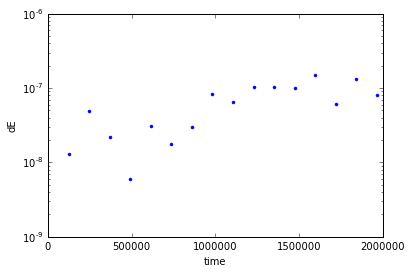

In [131]:
#Get energy at each checkpoint
sim = sa[0]
E0 = sim.calculate_energy()
dE = []
t = []

#get energies at each snapshot
for s in sa:
    dE.append(np.abs((s.calculate_energy() - E0)/E0))
    t.append(s.t)
    
plt.plot(t,dE,'.')
plt.ylabel("dE")
plt.xlabel("time")
plt.yscale('log')

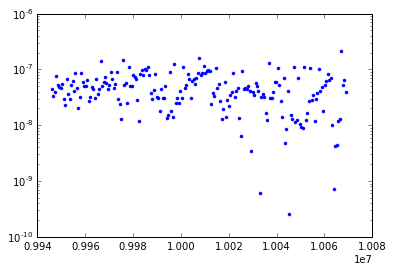

In [34]:
#simulate last few orbits - will take a second
sim = sa[0]
E0 = sim.calculate_energy()
dE = []
t = []

def collision(reb_sim, col):
    reb_sim.contents._status = 5 # causes simulation to stop running and have flag for whether sim stopped due to collision
    return 0

sim.collision = 'direct'
sim.collision_resolve = collision

s = sa[-1]
dt = sa[-1].t-sa[-2].t
for time in np.linspace(s.t,s.t+dt,200):
    s.integrate(time)
    t.append(s.t)
    dE.append(np.abs((s.calculate_energy() - E0)/E0))
    
plt.plot(t,dE,'.')
plt.yscale('log')

### Plot deviation of various orbital elements from simulation archives
See if orbital elements drift significantly even though it remained "stable" over 1e9 orbits.

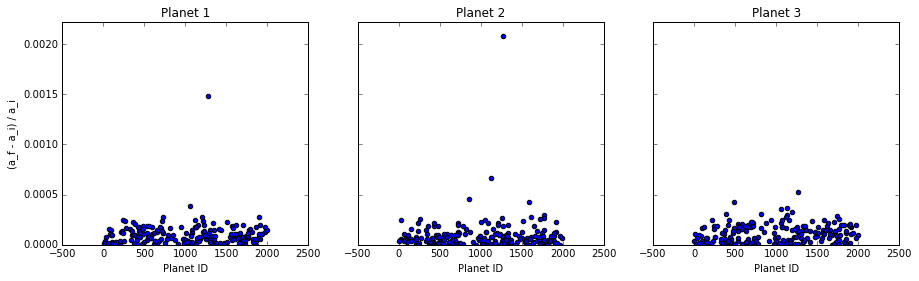

In [26]:
#prepare data
x = "a"     #what orbital element are you plotting?

shadow0 = Nbody[(Nbody["shadow"]==0)].copy()
d0 = data.iloc[shadow0["id"]]
shadow0["orbital_periods"] = shadow0["time"]/(d0["P1"].values*2*np.pi/365)
shadow0 = shadow0[shadow0["orbital_periods"]>9e8]

#get values
orbits = "1e9"
dir_ = "saved_output/%s_simulation_archives"%system
norm = []
for id_ in shadow0["id"]:
    sa = rebound.SimulationArchive("%s/%s_%sorbits_id%s_shadow0_SA.bin"%(dir_,system,orbits,id_))
    x1 = getattr(sa[0].particles[1],x)
    x2 = getattr(sa[0].particles[2],x)
    x3 = getattr(sa[0].particles[3],x)
    norm.append((np.abs(getattr(sa[-1].particles[1],x)-x1)/x1, #final - initial
                 np.abs(getattr(sa[-1].particles[2],x)-x2)/x2,
                 np.abs(getattr(sa[-1].particles[3],x)-x3)/x3))
    
o1, o2, o3 = np.asarray(zip(*norm))
    
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[15, 4], sharey=True)
ax1.scatter(shadow0["id"], o1)
ax2.scatter(shadow0["id"], o2)
ax3.scatter(shadow0["id"], o3)
ax1.set_ylim([0,1.5*max(o1)])
ax1.set_xlabel("Planet ID")
ax2.set_xlabel("Planet ID")
ax3.set_xlabel("Planet ID")
ax1.set_ylabel("(%s_f - %s_i) / %s_i"%(x,x,x))
ax1.set_title("Planet 1")
ax2.set_title("Planet 2")
ax3.set_title("Planet 3")

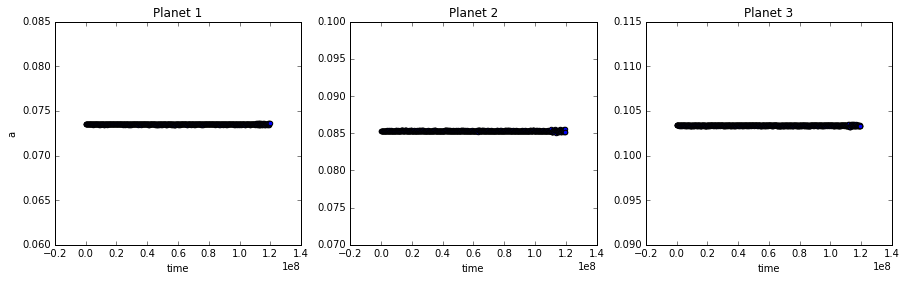

In [27]:
#check out specific system
i=0
ids = shadow0["id"].values
id_ = ids[np.where(o2 > 0.0015)[0][i]]

sa = rebound.SimulationArchive("%s/%s_%sorbits_id%s_shadow0_SA.bin"%(dir_,system,orbits,id_))
t, arr = [], []
for s in sa:
    arr.append((getattr(s.particles[1],x), getattr(s.particles[2],x), getattr(s.particles[3],x)))
    t.append(s.t)
    
a4, a5, a6 = zip(*arr)
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[15, 4])
ax1.scatter(t, a4)
ax2.scatter(t, a5)
ax3.scatter(t, a6)
ax1.set_xlabel("time")
ax2.set_xlabel("time")
ax3.set_xlabel("time")
ax1.set_ylabel(x)
ax1.set_title("Planet 1")
ax2.set_title("Planet 2")
ax3.set_title("Planet 3")

## Get Nbody candidates for Sunnyvale (delete if other notebook goes well)
Randomly sample from three stability probability ranges (low, medium, high). 

In [3]:
N_samples = 201
random.seed(42)
i1 = random.sample(np.where((results["predict_proba"] > 0.5)&(results["predict_proba"] < 0.8))[0],N_samples/3)
i2 = random.sample(np.where((results["predict_proba"] > 0.95)&(results["predict_proba"] < 1))[0],N_samples/3)
i3 = random.sample(np.where((results["predict_proba"] > 0)&(results["predict_proba"] < 0.2))[0],N_samples/3)
index = np.concatenate((i1,i2,i3))

In [4]:
data.loc[index].head()

,Unnamed: 0,m1,T1,P1,h1,k1,m2,T2,P2,h2,k2,m3,T3,P3,h3,k3
1230,1230,4.530855,782.277004,7.133316,0.012195,0.106623,3.956276,786.584302,8.918454,0.041161,0.072448,4.537668,780.277656,11.898409,0.001456,0.086238
60,60,4.547456,782.280037,7.133255,-0.006656,0.053905,3.373306,786.583675,8.918705,0.021472,0.025298,3.563987,780.278621,11.897841,-0.008360,0.043636
548,548,4.474383,782.279991,7.133339,-0.047261,-0.050273,3.059205,786.579632,8.918902,-0.017928,-0.068755,4.672306,780.281953,11.897719,-0.040550,-0.035504
479,479,3.608257,782.281796,7.133298,-0.069667,-0.019255,3.899398,786.576819,8.918871,-0.037733,-0.040086,3.966241,780.277549,11.898036,-0.060336,-0.010253
1372,1372,4.447658,782.278745,7.133359,-0.007968,0.057125,3.084179,786.583734,8.918563,0.019812,0.029353,3.974266,780.272778,11.898063,-0.008526,0.046389


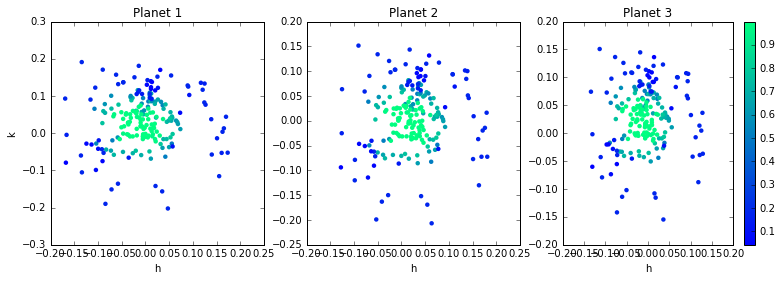

In [5]:
# Plot Nbody Candidates
x = "h"
y = "k"
proba = results["predict_proba"].loc[index].values

colorbar = 'winter'
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[13, 4])
ax1.scatter(data["%s1"%x].loc[index], data["%s1"%y].loc[index], c=proba, cmap=colorbar, lw=0)
ax2.scatter(data["%s2"%x].loc[index], data["%s2"%y].loc[index], c=proba, cmap=colorbar, lw=0)
c=ax3.scatter(data["%s3"%x].loc[index], data["%s3"%y].loc[index], c=proba, cmap=colorbar, lw=0)

ax1.set_ylabel(y) 
ax1.set_xlabel(x)
ax2.set_xlabel(x)
ax3.set_xlabel(x)
ax1.set_title("Planet 1")
ax2.set_title("Planet 2")
ax3.set_title("Planet 3")
cb = f.colorbar(c)
plt.savefig("images/%s_%s%s_Nbodycandidates.png"%(system,x,y))

## Generate Sunnyvale jobs

In [28]:
norbits = 1e9            #number of orbits of innermost planet
dir = 'jobs/'

f2 = open("systems/%s_NbodyIDs.csv"%system,"w"); f2.write("Nbody IDs\n")
for shadow in [0,1]:
    for sample in data.loc[index].iterrows():
        id_ = sample[0]    #id number of sample
        job_name = "%s_1e%dorbits_id%d_shadow%d"%(system,int(np.log10(norbits)),id_,shadow)
        sh_script_name = "%s%s"%(dir,job_name)
        with open(sh_script_name, 'w') as f:
            f_head = open('job_header_sunnyvale','r')
            f.write(f_head.read())
            f_head.close()
            f.write('#PBS -N %s \n'%job_name)
            f.write('# EVERYTHING ABOVE THIS COMMENT IS NECESSARY, SHOULD ONLY CHANGE nodes,ppn,walltime and my_job_name VALUES\n')
            f.write('cd $PBS_O_WORKDIR\n')      #This will be the home stability_predict directory
            f.write('source ../venv/bin/activate \n')
            f.write('python run_Nbody.py %d %f %.2f %d %d %s >& batch.output\n'%(id_,Ms[system],epoch,norbits,shadow,job_name))
        f.close()
        if shadow == 0:
            f2.write("%d\n"%id_)
f2.close()